In [1]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import pickle

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

#VIS
from keras.utils.vis_utils import plot_model

In [2]:
BASE_PATH = '/Users/hamnamoieez/Desktop/PRDL/Distracted-Driver-Detection-Using-Deep-Learning/'
img_path = os.path.join(BASE_PATH, 'imgs/train')
test_path =  os.path.join(BASE_PATH, 'imgs/test/')
weights_path = os.path.join(BASE_PATH, 'weights/')
class_mapper = {0: "safe driving",
                1: "texting - right",
                2: "talking on the phone - right",
                3: "texting - left",
                4: "talking on the phone - left",
                5: "operating the radio",
                6: "drinking",
                7: "reaching behind",
                8: "hair and makeup",
                9: "talking to passenger"}

In [3]:
def _prepareData(path): 
    '''
    params: path(string)
    return: [list list] of images in dataset and the list of labels
    '''
    labelsList = []
    listOfimg = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for img in glob.glob(os.path.join(directory,'*.jpg')):
                imgcv = cv2.imread(img)
                imgcv_r = cv2.resize(imgcv,(112,112))
                listOfimg.append(imgcv_r)
                labelsList.append(int(directory.split("/")[-1].replace('c','')))
    
    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(listOfimg,labelsList, test_size = 0.2)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

In [91]:
#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(img_path)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))

Size X_Train: 17939, Size Y_Train: 17939
Size X_Test: 4485, Size Y_Test: 4485


In [92]:
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
    ])
    return model

In [3]:
NUM_CLASSES = 10
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10
BATCH_SIZE = 8
INPUT_SHAPE = (112,112,3)

In [93]:


def compile_model(model, learning_rate):
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    print(model.summary())
    return model


def fit_model(model, initial_epochs, batch_size, train_data, train_labels):
    history = model.fit(x = train_data, y = train_labels,
                        epochs = initial_epochs, batch_size = batch_size,
                        verbose = 1,validation_split=0.2)
    model.save(weights_path+"_model.h5")
    return history

def plot_accuracy(history, model_name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(model_name+' Accuray')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.ylim([0.9,1])
    plt.legend(['train','test'], loc='upper left')
    plt.show()
    
def plot_loss(history, model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(model_name+' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.ylim([0,.4])
    plt.legend(['train','test'], loc='upper left')
    plt.show()


In [94]:
custom = create_model(INPUT_SHAPE, NUM_CLASSES)
custom_model = compile_model(custom, LEARNING_RATE)
cus_history = fit_model(custom_model, NUM_EPOCHS, BATCH_SIZE, X_Train, Y_Train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0

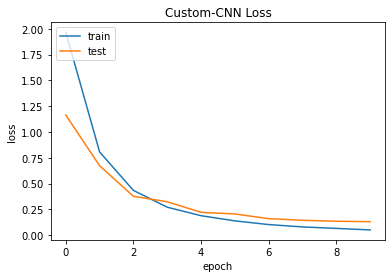

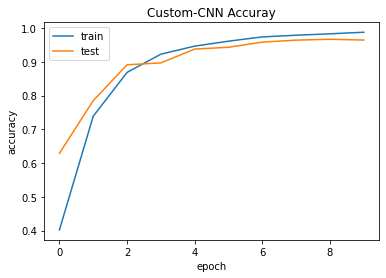

In [95]:
plot_loss(cus_history, 'Custom-CNN')
plot_accuracy(cus_history, 'Custom-CNN')

In [99]:
test_loss, test_acc = custom_model.evaluate(X_Test, Y_Test, verbose = 1)

141/141 [==============================] - 6s 42ms/step - loss: 0.1134 - accuracy: 0.9659


In [4]:
img = image.load_img(test_path+'img_18.jpg', target_size=(112, 112))

In [5]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
image = np.vstack([img_batch])

In [6]:
model = keras.models.load_model(weights_path+'_model.h5')

In [7]:
prediction = model.predict(image)

In [8]:
class_pred =np.argmax(prediction,axis=1)
print(class_pred)

[1]


In [9]:
predicted_class_name = [class_mapper[k] for k in class_pred]
print(predicted_class_name[0])

texting - right


In [ ]:
import json
 
# Opening JSON file
with open('concepts.json') as json_file:
    data = json.load(json_file)
 
    # Print the type of data variable
    print("Type:", type(data))